In [11]:
import numpy as np
import yaml

from scipy.interpolate import interp1d

import camb
from camb import model, initialpower

from matplotlib import pyplot as plt

import sys
sys.path.append('lss_likelihood/')
from linear_theory import D_of_a

In [6]:
cosmo = yaml.load(open('../KP5/emulator/cosmo_pars.yaml'), Loader=yaml.SafeLoader)

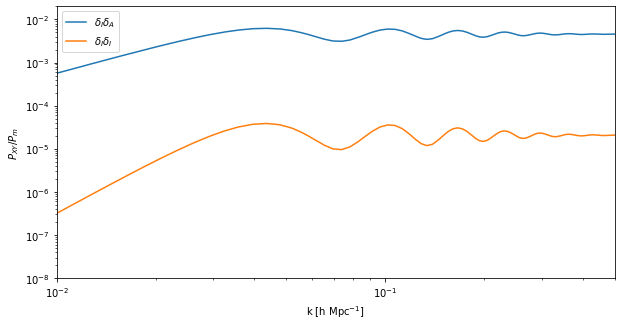

In [229]:
#Get matter power spectra for redshifts
#redshifts= [4.0,3.5,3.0,2.5,2.0,1.5,1.0,0.5,0.0]
redshifts = [15]
#nnu=1
#mnu = 0.06
nnu=0
mnu=0
H0=67.70
ombh2=0.022447
omch2=0.11923
As=np.exp(3.0480)*1e-10
ns=0.96824
tau = 0.0568

# Fabian Schmidt's paper:
#h = 0.7
#H0 = 100 * h
#ombh2 = 0.023
#omch2 = 0.27 * h**2 - ombh2
#ns = 0.95


pars = camb.CAMBparams()
pars.set_cosmology(H0=cosmo['h']*100, ombh2=cosmo['omega_b'], omch2=cosmo['omega_cdm'], mnu=cosmo['omega_ncdm']/0.0106, num_massive_neutrinos=1,tau=0.054)
pars.set_dark_energy() #re-set defaults
pars.InitPower.set_params(ns=cosmo['n_s'], As=cosmo['A_s'])
#Not non-linear corrections couples to smaller scales than you want
pars.set_dark_energy()
pars.set_matter_power(redshifts=redshifts, kmax=10)
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)

# Let's ignore neutrinos for now... small effect on a small effect
Dz =  D_of_a(1./(1.+redshifts[0]), OmegaM=(cosmo['omega_b']+cosmo['omega_cdm'])/cosmo['h']**2)

tf = results.get_matter_transfer_data().transfer_data
tf_k = tf[0,:,0]
tf_m = tf[6,:,0] / Dz
tf_i = np.abs(tf[1,:,0] - tf[2,:,0])
#tf_v = (tf[10,:,0] - tf[11,:,0]) / (1+redshifts[0])**2 * planck.H(redshifts[0])


# Note: transfer functions are defined *at redshift 0*
tf_i_rat = interp1d(tf_k, tf_i/tf_m)
#tf_v_rat = interp1d(tf_k, tf_v/tf_m)

# here we have i = b-c, v = theta_bc
kh, z, pk_aa = results.get_matter_power_spectrum(var1='delta_tot', var2='delta_tot', minkh=1e-3, maxkh=10, npoints = 2000)

pks = np.zeros( (7,len(kh)) )
pks[0,:] = kh
pks[1,:] = pk_aa[0,:] /  Dz**2
pks[2,:] = tf_i_rat(kh) * pk_aa[0,:] / Dz**2
#pks[3,:] = tf_v_rat(kh) * pk_aa[0,:] / planck.iDz(redshifts[0])**2
pks[4,:] = tf_i_rat(kh) * tf_i_rat(kh) * pk_aa[0,:] / Dz**2
#pks[5,:] = tf_v_rat(kh) * tf_i_rat(kh) * pk_aa[0,:] / planck.iDz(redshifts[0])**2
#pks[6,:] = tf_v_rat(kh) * tf_v_rat(kh) * pk_aa[0,:] / planck.iDz(redshifts[0])**2

#np.save('../data/pks_planck2018.npy', pks)

plt.figure(figsize=(10,5))

plt.loglog(kh, tf_i_rat(kh),label=r'$\delta_I \delta_A$')
#plt.loglog(kh, tf_v_rat(kh),label=r'$\theta_I \delta_A$')

plt.loglog(kh, tf_i_rat(kh)**2,label=r'$\delta_I \delta_I$')
#plt.loglog(kh, tf_v_rat(kh) * tf_i_rat(kh),label=r'$\delta_I \theta_I$')
#plt.loglog(kh, tf_v_rat(kh)**2,label=r'$\theta_I \theta_I$')

#plt.loglog(kh, 6.8 * planck.H(redshifts[0]) / (1+redshifts[0])**2 * tf_v_rat(kh),'k')

plt.xlim([0.01,0.5])
plt.ylim([1e-8,2e-2])
plt.ylabel(r'$P_{XY}/P_m$')
plt.xlabel(r'k [h Mpc$^{-1}$]')
plt.legend()

(0.0, 0.5)

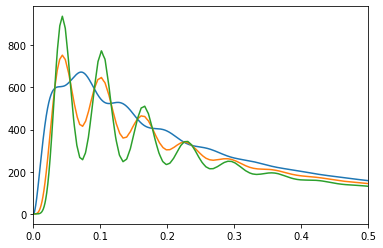

In [230]:
plt.plot(kh, kh * pks[1,:])
plt.plot(kh, 200 * kh * pks[2,:])
plt.plot(kh, 200**2 * kh * pks[4,:])

plt.xlim(0,0.5)

### Wiggle No Wiggle Split

In [231]:
from pnw_dst import pnw_dst

In [232]:
knw, pnw = pnw_dst(kh, pks[2,:])

142 160
106 159


(0.0, 0.5)

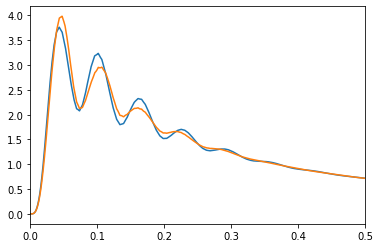

In [234]:
# This doesn't work
plt.plot(kh, kh * pks[2,:])
plt.plot(knw, knw * pnw)


plt.xlim(0,0.5)

In [235]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from scipy.signal import argrelmin, argrelmax, tukey
from scipy.fftpack import dst, idst
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

In [282]:
# put onto a linear grid
ks = np.linspace( 1e-3, 10, 2**16)

n = 2

lnps = Spline(kh, np.log(kh**n*pks[2,:]), ext=1)(ks)

dst_ps = dst(lnps)
dst_odd = dst_ps[1::2]
dst_even = dst_ps[0::2]

(-10000.0, 10000.0)

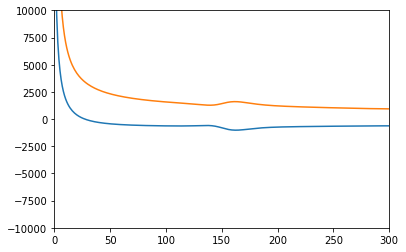

In [283]:
plt.plot(dst_odd)
plt.plot(-dst_even)

plt.xlim(0,300)
plt.ylim(-10000,10000)

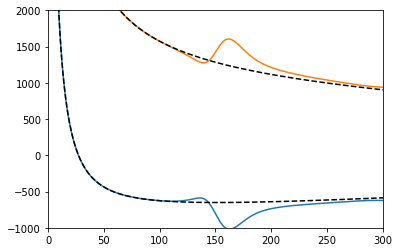

In [313]:
#ii_l, ii_r = 110, 220

ii_l, ii_r = 80, 400

iis = np.arange(len(dst_odd))
iis_div = np.copy(iis); iis_div[0] = 1.
cutiis_odd = (iis > (ii_l) ) * (iis < (ii_r) )
cutiis_even = (iis > (ii_l) ) *  (iis < (ii_r) )

# ... and interpolate over them
interp_odd = interp1d(iis[~cutiis_odd],(iis**2*dst_odd)[~cutiis_odd],kind='cubic')(iis)/iis_div**2 
interp_odd[0] = dst_odd[0]
    
interp_even = interp1d(iis[~cutiis_even],(iis**2*dst_even)[~cutiis_even],kind='cubic')(iis)/iis_div**2 
interp_even[0] = dst_even[0]
    
plt.plot(dst_odd)
plt.plot(-dst_even)

plt.xlim(0,300)
plt.ylim(-1000,2000)
#plt.ylim(-10000,10000)
    
plt.plot(interp_odd, 'k--')
plt.plot(-interp_even, 'k--')

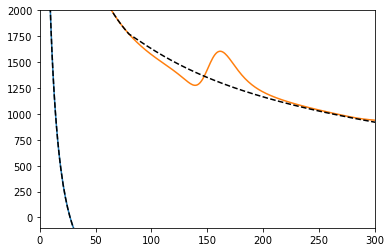

In [309]:
from scipy.interpolate import PchipInterpolator

# ... and interpolate over them
interp_odd = PchipInterpolator(iis[~cutiis_odd],(iis**2*dst_odd)[~cutiis_odd])(iis)/iis_div**2 
interp_odd[0] = dst_odd[0]
    
interp_even = PchipInterpolator(iis[~cutiis_even],(iis**2*dst_even)[~cutiis_even])(iis)/iis_div**2 
interp_even[0] = dst_even[0]
    
plt.plot(dst_odd)
plt.plot(-dst_even)

plt.xlim(0,300)
plt.ylim(-100,2000)
    
plt.plot(interp_odd, 'k--')
plt.plot(-interp_even, 'k--')

In [373]:
# Transform back
interp = np.zeros_like(dst_ps)
interp[0::2] = interp_even
interp[1::2] = interp_odd

lnps_nw = idst(interp) / 2**17
    
pnw_ia =  Spline(ks, np.exp(lnps_nw)/ks**n,ext=1)(kh)
pw_ia = pks[2,:] - pnw_ia

(0.0, 0.5)

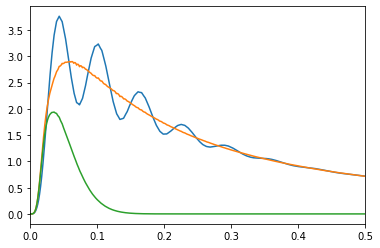

In [374]:
plt.plot(kh, kh * pks[2,:])

plt.plot(knw, knw * pnw_ia)

plt.plot(knw, knw * pnw_ia * np.exp(-(knw*15)**2))


plt.xlim(0,0.5)

(0.7, 1.8)

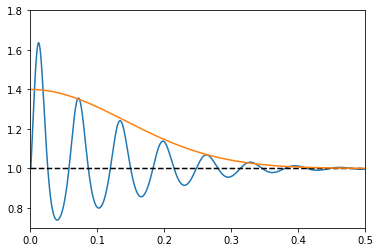

In [375]:
plt.plot(knw, pnw_ia/pks[2,:])

plt.plot(knw, knw * 0 + 1, 'k--')

plt.plot(knw, 0.4 * np.exp(-(5*knw)**2) + 1 )

plt.xlim(0,0.5)
plt.ylim(0.7,1.8)

In [376]:
# Now make the post-recon signal

In [377]:
klin, plin = np.loadtxt('templates/desi_pk.txt', unpack=True)
klin, pnw = np.loadtxt('templates/desi_pnw.txt', unpack=True)

pw = plin - pnw

(0.0, 0.3)

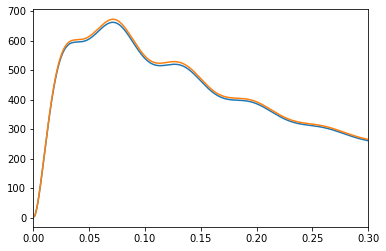

In [378]:
# Close enough...

plt.plot(klin, klin * plin)
plt.plot(knw, knw * pks[1,:])

plt.xlim(0,0.3)

In [388]:
from linear_theory import*
from scipy.special import spherical_jn
from scipy.integrate import simps

zfid = 0.8
OmM_fid = 0.3
Rsmooth = 15
rsdrag_fid = 100

Dz   = D_of_a(1/(1.+zfid), OmegaM=OmM_fid)
f0   = f_of_a(1/(1.+zfid), OmegaM=OmM_fid)

Sk = np.exp(-0.5*(klin*Rsmooth)**2)
j0 = spherical_jn(0,klin*rsdrag_fid)        

sigmadd = Dz**2 * simps( 2./3 * plin * (1-Sk)**2 * (1-j0), x = klin) / (2*np.pi**2)
sigmass = Dz**2 * simps( 2./3 * plin * (-Sk)**2 * (1-j0),  x = klin) / (2*np.pi**2)

sigmads_dd = Dz**2 * simps( 2./3 * plin * (1-Sk)**2, x = klin) / (2*np.pi**2)
sigmads_ss = Dz**2 * simps( 2./3 * plin * (-Sk)**2, x = klin) / (2*np.pi**2)
sigmads_ds = -Dz**2 * simps(2./3 * plin * (1-Sk)*(-Sk)*j0, x = klin) / (2*np.pi**2)

In [389]:
pnw_ia = interp1d(kh, pnw_ia, kind='cubic')(klin)
pw_ia = interp1d(kh, pw_ia, kind='cubic')(klin)

In [400]:
B1, F = 1.1453427999999999, 0.77740741

def compute_bao_pkmu(mu, mode='Zel',sigma_emp = sigmadd, bb=False):
    rsd_fac = 1 + f0*(2+f0)*mu**2
    dampfac_dd = np.exp( -0.5 * klin**2 * (sigmadd * rsd_fac) )
    return 2 *  ( (1 + F*mu**2) + B1 ) * (dampfac_dd * pw_ia + pnw_ia * bb)

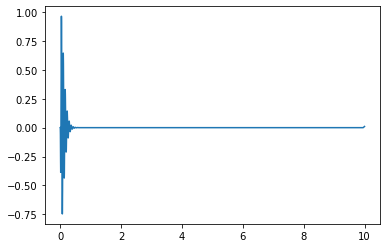

In [401]:
plt.plot(klin, klin * (pw_ia))

In [402]:
ngauss = 4
nus, ws = np.polynomial.legendre.leggauss(2*ngauss)
nus_calc = nus[0:ngauss]
        
L0 = np.polynomial.legendre.Legendre((1))(nus)
L2 = np.polynomial.legendre.Legendre((0,0,1))(nus)
L4 = np.polynomial.legendre.Legendre((0,0,0,0,1))(nus)

In [403]:
pknutable = np.zeros((len(nus),len(klin)))
    
for ii, nu in enumerate(nus_calc):
    pknutable[ii,:] = compute_bao_pkmu(nu, bb=True)

pknutable[ngauss:,:] = np.flip(pknutable[0:ngauss],axis=0)
        
p0_zel = 0.5 * np.sum((ws*L0)[:,None]*pknutable,axis=0)
p2_zel = 2.5 * np.sum((ws*L2)[:,None]*pknutable,axis=0)

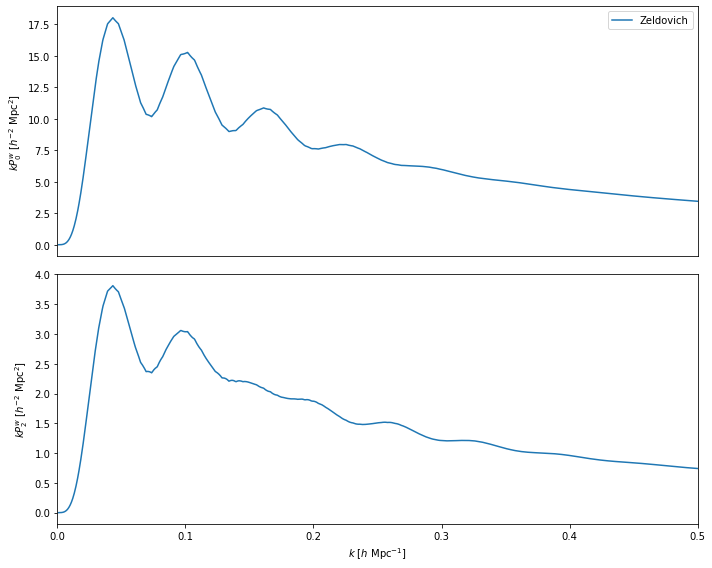

In [404]:
plt.figure(figsize=(10,8))

plt.subplot(2,1,1)

plt.plot(klin, klin * p0_zel, 'C0', label='Zeldovich')


plt.xticks([])
plt.xlim(0,0.5)

plt.ylabel(r'$k P^w_0$ [$h^{-2}$ Mpc$^2$]')

plt.legend()

plt.subplot(2,1,2)

plt.plot(klin, klin * p2_zel, 'C0')

plt.xlim(0,0.5)

plt.ylabel(r'$k P^w_2$ [$h^{-2}$ Mpc$^2$]')
plt.xlabel(r'$k$ [$h$ Mpc$^{-1}$]')

plt.tight_layout()

In [406]:
np.savetxt('fake_data/linear_template_deltabc.txt', np.array([klin, p0_zel, p2_zel]) )